In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
try:
    df = pd.read_csv('../data/heart_disease_cleaned.csv')
    print("Cleaned dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'heart_disease_cleaned.csv' not found.")
    print("Please run the data preprocessing script first to generate this file.")
    # As a fallback, create a dummy dataframe
    print("Creating a dummy dataframe for demonstration purposes.")
    data = {
        'age': np.random.rand(303), 'sex': np.random.rand(303), 'cp': np.random.rand(303),
        'trestbps': np.random.rand(303), 'chol': np.random.rand(303), 'fbs': np.random.rand(303),
        'restecg': np.random.rand(303), 'thalach': np.random.rand(303), 'exang': np.random.rand(303),
        'oldpeak': np.random.rand(303), 'slope': np.random.rand(303), 'ca': np.random.rand(303),
        'thal': np.random.rand(303), 'target': np.random.randint(0, 2, 303)
    }
    df = pd.DataFrame(data)

Cleaned dataset loaded successfully.


In [3]:
X = df.drop('target', axis=1)
y = df['target']

In [6]:
try:
    df_unscaled = pd.read_csv('../data/heart_disease.csv', header=None)
    column_names = [
        'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
        'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'
    ]
    df_unscaled.columns = column_names
    df_unscaled.replace('?', np.nan, inplace=True)

    # FIX: Convert all columns to numeric, which will turn any header text into NaN
    for col in df_unscaled.columns:
        df_unscaled[col] = pd.to_numeric(df_unscaled[col], errors='coerce')

    # Now, drop any rows with NaN values (which would include the header if it was present)
    df_unscaled.dropna(inplace=True)

    # Ensure target is of integer type for consistency
    df_unscaled['target'] = df_unscaled['target'].astype(int)

    X_unscaled = df_unscaled.drop('target', axis=1)
    y_unscaled = df_unscaled['target']

except FileNotFoundError:
    X_unscaled, y_unscaled = X, y

In [7]:
print("\n--- Method 1: Chi-Square Test ---")

chi2_selector = SelectKBest(score_func=chi2, k=10)
chi2_selector.fit(X_unscaled, y_unscaled)


--- Method 1: Chi-Square Test ---


,score_func,<function chi...0023C28AE9E40>
,k,10


In [8]:
chi2_scores = pd.DataFrame({'Feature': X.columns, 'Score': chi2_selector.scores_})
print("Chi-Square Scores for each feature:")
print(chi2_scores.sort_values(by='Score', ascending=False))

Chi-Square Scores for each feature:
     Feature       Score
7    thalach  219.883557
11        ca  107.213553
9    oldpeak   98.505523
12      thal   70.520283
8      exang   39.119182
4       chol   38.167452
0        age   27.975233
3   trestbps   19.348090
2         cp   16.383180
6    restecg   13.026434
10     slope   10.178421
1        sex    7.511646
5        fbs    6.778461


In [9]:
print("\n--- Method 2: Random Forest Feature Importance ---")
# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, y)


--- Method 2: Random Forest Feature Importance ---


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [11]:
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("Feature importances from Random Forest:")
print(feature_importance_df)

Feature importances from Random Forest:
     Feature  Importance
7    thalach    0.138306
9    oldpeak    0.122138
4       chol    0.116422
0        age    0.113967
11        ca    0.097398
3   trestbps    0.091751
12      thal    0.077441
2         cp    0.075563
8      exang    0.047884
10     slope    0.042916
1        sex    0.028483
6    restecg    0.027269
5        fbs    0.020461


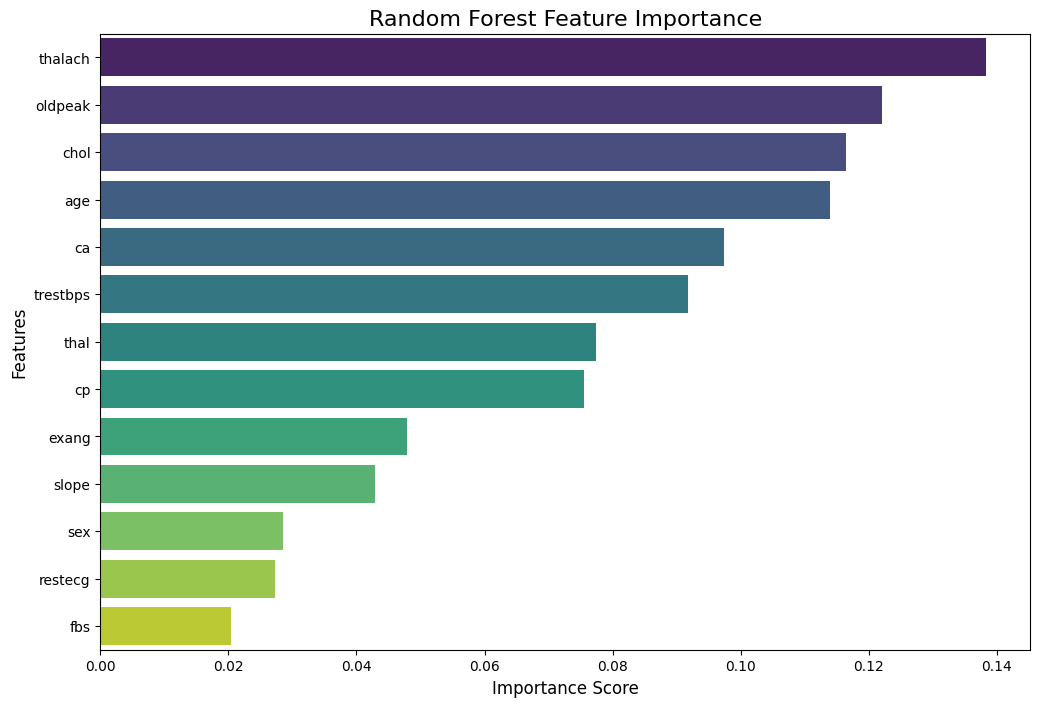

In [13]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis', hue='Feature', legend=False)
plt.title('Random Forest Feature Importance', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.show()

In [14]:
print("\n--- Method 3: Recursive Feature Elimination (RFE) ---")
# We will aim to select the top 8 features, a common choice for this dataset.
# The estimator can be any model that provides feature weights (e.g., Logistic Regression, SVM).
estimator = LogisticRegression(max_iter=1000)
rfe_selector = RFE(estimator=estimator, n_features_to_select=8, step=1)
rfe_selector.fit(X, y)


--- Method 3: Recursive Feature Elimination (RFE) ---


,estimator,LogisticRegre...max_iter=1000)
,n_features_to_select,8
,step,1
,verbose,0
,importance_getter,'auto'
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1


In [15]:
selected_features_mask = rfe_selector.support_
selected_features = X.columns[selected_features_mask]

print(f"\nTop {len(selected_features)} features selected by RFE:")
print(list(selected_features))


Top 8 features selected by RFE:
['sex', 'cp', 'fbs', 'restecg', 'exang', 'oldpeak', 'slope', 'ca']


In [16]:
X_selected = X[selected_features]
final_df = pd.concat([X_selected, y], axis=1)

In [17]:
final_df.to_csv('../data/heart_disease_selected_features.csv', index=False)
print("\nDataset with selected features saved to 'heart_disease_selected_features.csv'")


Dataset with selected features saved to 'heart_disease_selected_features.csv'


In [18]:
print(final_df.head())

   sex   cp  fbs  restecg  exang   oldpeak  slope   ca  target
0  1.0  1.0  1.0      2.0    0.0  1.087338    3.0  0.0       0
1  1.0  4.0  0.0      2.0    1.0  0.397182    2.0  3.0       2
2  1.0  4.0  0.0      2.0    1.0  1.346147    2.0  2.0       1
3  1.0  3.0  0.0      0.0    0.0  2.122573    3.0  0.0       0
4  0.0  2.0  0.0      2.0    0.0  0.310912    1.0  0.0       0
